## LGA Airline Passengers

In [1]:
import json 
import pandas as pd 
import numpy as np 
import math 
import itertools 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# True labels
annotations = pd.read_json('TCPD-master/annotations.json')
annotations[['lga_passengers']]

,lga_passengers
6,"[169, 296, 384]"
7,[]
8,"[169, 296, 385]"
9,"[14, 84, 122, 164, 231, 298, 384]"
10,NaN
12,"[132, 169, 296, 382]"
13,NaN
14,NaN


In [3]:
# List true changepoints
annotator_df = pd.read_json('TCPD-master/annotations.json') 
lga_passengers_df = annotator_df[['lga_passengers']] 
list2d = np.array(lga_passengers_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
lga_passengers_annotation_lst = list(itertools.chain.from_iterable(list2d))
lga_passengers_annotation_lst

[169,
 296,
 384,
 169,
 296,
 385,
 14,
 84,
 122,
 164,
 231,
 298,
 384,
 132,
 169,
 296,
 382]

t                         int64
Number of Passengers    float64
date                     object
dtype: object


<Figure size 960x480 with 0 Axes>

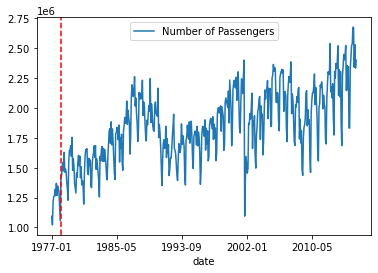

In [4]:
# Plot true changepoints
from load_dataset import TimeSeries
ts = TimeSeries.from_json('TCPD-master/datasets/lga_passengers/lga_passengers.json')
lga_passengers_df = ts.df
lga_passengers_df['date'] =ts.datestr
print(lga_passengers_df.dtypes)
figure(figsize=(12, 6), dpi=80)
lga_passengers_df.plot('date', 'Number of Passengers')
lga_passengers_df['is_CPD'] = np.where(lga_passengers_df.t.isin(lga_passengers_annotation_lst), 1,0)
plt.axvline(lga_passengers_df.loc[lga_passengers_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--')

In [5]:
lga_passengers_df[295:385]

,t,Number of Passengers,date,is_CPD
295,295,2400420.0,2001-08,0
296,296,1094429.0,2001-09,1
297,297,1397716.0,2001-10,0
298,298,1594152.0,2001-11,1
299,299,1526117.0,2001-12,0
...,...,...,...,...
380,380,1740889.0,2008-09,0
381,381,1906311.0,2008-10,0
382,382,1706577.0,2008-11,1
383,383,1812050.0,2008-12,0


In [6]:
lga_passengers_df.shape

(468, 4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



total changepoints-->  1


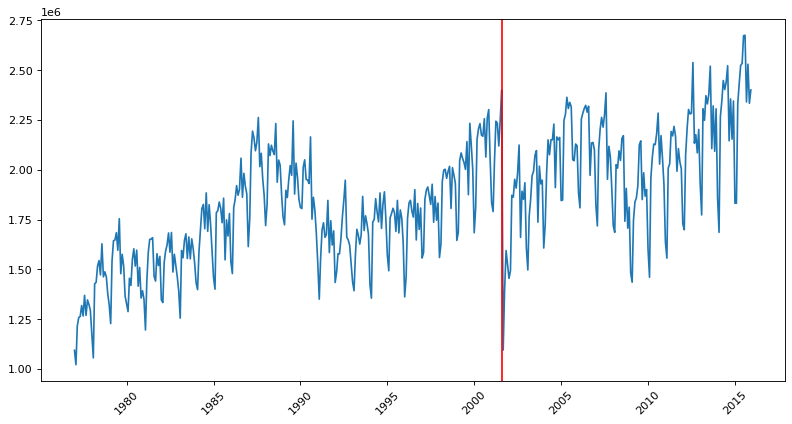

In [7]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

df = lga_passengers_df
df['time']= pd.to_datetime(df['date'])


tsd = TimeSeriesData(df.loc[:,['time','Number of Passengers']])

# Initialize the detector
detector = BOCPDetector(tsd)


changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=10,
    changepoint_prior=.5,#prior belief
    threshold=.9
)

print('total changepoints--> ', len(changepoints))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

In [8]:
changepoints

[(TimeSeriesChangePoint(start_time: 2001-08-01T00:00:00.000000000, end_time: 2001-08-01T00:00:00.000000000, confidence: 0.9787286716001473),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7febceee1430>)]

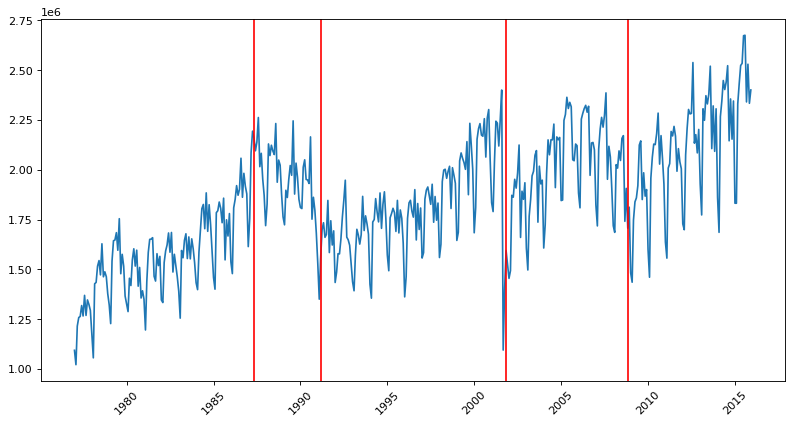

In [40]:
#Robust Stat Detector
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(comparison_window=12, smoothing_window_size=12, p_value_cutoff=0.05)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [24]:
change_points

[(TimeSeriesChangePoint(start_time: 1987-05-01T00:00:00.000000000, end_time: 1987-05-01T00:00:00.000000000, confidence: 0.9557293461002967),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fb304fce3a0>),
 (TimeSeriesChangePoint(start_time: 1991-03-01T00:00:00.000000000, end_time: 1991-03-01T00:00:00.000000000, confidence: 0.9511425777686568),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fb304fce550>),
 (TimeSeriesChangePoint(start_time: 2001-11-01T00:00:00.000000000, end_time: 2001-11-01T00:00:00.000000000, confidence: 0.9764513083806724),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fb304fce4c0>),
 (TimeSeriesChangePoint(start_time: 2008-11-01T00:00:00.000000000, end_time: 2008-11-01T00:00:00.000000000, confidence: 0.9658771002736218),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fb304fce760>)]

total changepoints-->  1


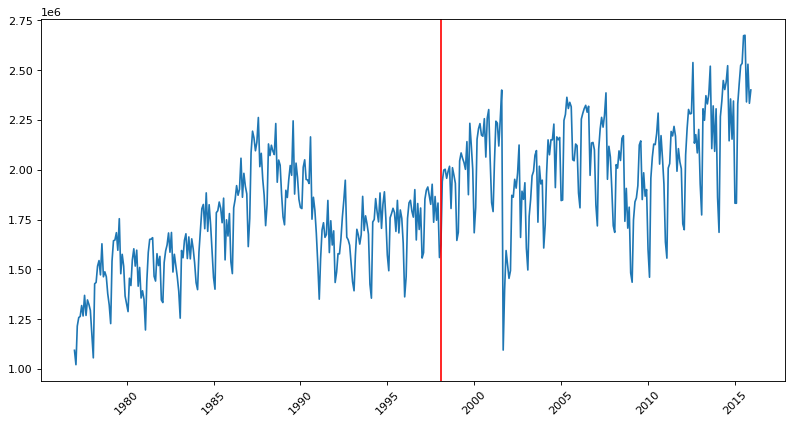

In [11]:
# CUSUM
from kats.detectors.cusum_detection import CUSUMDetector


# Initialize the detector
detector = CUSUMDetector(tsd)

change_points = detector.detector(threshold=0.05)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [12]:
change_points

[(TimeSeriesChangePoint(start_time: 1998-02-01 00:00:00, end_time: 1998-02-01 00:00:00, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7febc6e09fd0>)]

#### Annotation -> 1991
#### BOCPD -> 2001
#### RobustStatDetector -> 1994
#### CUSUM -> 1998

In [10]:
#def to parse list of changepoints and confidence
def parse_CPs(changepoints):    
    cp_list = []
    for cp in changepoints:
        changepoint = str(cp[0])[34:38]
        confidence = str(cp[0])[119:125]
        cp_list.append(changepoint)
    return cp_list

In [8]:
#Robust Stat Detector
from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.consts import TimeSeriesData

df = lga_passengers_df
df['time']= pd.to_datetime(df['date'])
tsd = TimeSeriesData(df.loc[:,['time','Number of Passengers']])

#Hyperparameter tuning for RSD model
def hp_tuning_RSD(df):

    # Initialize the detector
    detector = RobustStatDetector(tsd)

    hp_list = []
    #hp_result['true_CP_detected'] = []
    comparison_window = 0
    smoothing_window_size = 0
    p_value_cutoff = 0.05
    hp_value = {}
    for i in range(1,469):
        for j in range(1, 469):
            #for k in range(1, 10):
                #threshold = k*0.1
            smoothing_window_size = i
            comparison_window = j
            change_points = detector.detector(
                comparison_window=comparison_window,
                smoothing_window_size=smoothing_window_size,
                p_value_cutoff=0.05
            )
            hp_value = {'comparison_window': comparison_window, 'smoothing_window': smoothing_window_size, 'CP': parse_CPs(change_points)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [11]:
LGA_hp_rsd = hp_tuning_RSD(tsd)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:2419: RuntimeWarning:

invalid value encountered in true_divide

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/kats/detectors/robust_stat_detection.py:70: RuntimeWarning:

invalid value encountered in less



In [13]:
LGA_hp_rsd.to_csv("LGA_hp_rsd.csv")